# Notebook 04: Data Modeling (Multi-Model Comparison)

**Mục tiêu:** Huấn luyện và so sánh các mô hình Binary Classification để tìm ra model tốt nhất.

**Các mô hình sử dụng:**
1. **XGBoost:** Gradient Boosting (Mạnh mẽ, chuẩn công nghiệp).
2. **Decision Tree:** Cây quyết định (Đơn giản, dễ diễn giải, inference nhanh).
3. **Logistic Regression:** Linear (Đơn giản, tốc độ cao, làm baseline).

**Input:** `train_features_selected.pkl` (6 features đã chọn từ Notebook 03)
**Output:** `best_model.pkl` (Model tốt nhất được chọn tự động).

**Chiến lược:**
1. Sử dụng dữ liệu gộp (Train + Validation) từ Notebook 03.
2. Áp dụng **Stratified K-Fold** (5 Folds) để đánh giá.
3. Huấn luyện model cuối cùng trên toàn bộ dữ liệu gộp.

In [10]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- CẤU HÌNH ---
# Sử dụng file features đã chọn (6 features)
INPUT_FILE = '../../dataset_final/clean_data/train_features_selected.pkl'
MODEL_DIR = '../../dataset_final/models'
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_OUTPUT_PATH = os.path.join(MODEL_DIR, 'best_matcher.pkl')
FEATURE_LIST_PATH = os.path.join(MODEL_DIR, 'feature_names.pkl')

N_FOLDS = 5
RANDOM_STATE = 42

# --- DANH SÁCH 6 FEATURES ĐÃ CHỌN (từ Notebook 03) ---
SELECTED_FEATURES = [
    'feat_title_tfidf_cosine',   # 0.96 - Bắt semantic/keywords
    'feat_title_len_diff',       # -0.54 - Phát hiện title bị cắt/thiếu
    'feat_auth_jaccard',         # 0.88 - Overlap tên tác giả
    'feat_year_match',           # 0.51 - Năm khớp chính xác
    'feat_id_match',             # 0.40 - arXiv/DOI match (Golden)
    'feat_first_auth_match',     # 0.31 - Tác giả đầu tiên khớp
]

print(f"✅ Sử dụng {len(SELECTED_FEATURES)} features đã chọn")

✅ Sử dụng 6 features đã chọn


## 1. Load và Chuẩn bị Dữ liệu

In [11]:
# 1. Load Data
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"❌ Chưa có file {INPUT_FILE}. Hãy chạy lại NB03 (phần Feature Selection).")

df = pd.read_pickle(INPUT_FILE)

# Tách X, y
y = df['label'].astype(int)

# Sử dụng SELECTED_FEATURES (đã định nghĩa sẵn)
X = df[SELECTED_FEATURES]

print(f"Dataset Shape (Train + Valid combined): {X.shape}")
print(f"Số lượng Features: {len(SELECTED_FEATURES)}")
print(f"Features sử dụng: {SELECTED_FEATURES}")
print(f"\nPhân bố nhãn:\n{y.value_counts()}")

Dataset Shape (Train + Valid combined): (67275, 6)
Số lượng Features: 6
Features sử dụng: ['feat_title_tfidf_cosine', 'feat_title_len_diff', 'feat_auth_jaccard', 'feat_year_match', 'feat_id_match', 'feat_first_auth_match']

Phân bố nhãn:
label
0    53820
1    13455
Name: count, dtype: int64


## 2. Cấu hình các Model
Chúng ta định nghĩa danh sách các model cần "thi đấu".

**Thay đổi:** Thay **Random Forest** bằng **Decision Tree** vì:
- Inference nhanh hơn (chỉ 1 cây thay vì 300 cây)
- Dễ diễn giải hơn (có thể visualize cây)
- Với 6 features đã chọn, Decision Tree đủ sức phân loại tốt

*Lưu ý:* **Logistic Regression** cần `StandardScaler` để chuẩn hóa dữ liệu.

In [12]:
models_config = {
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, eval_metric='logloss',
        use_label_encoder=False, random_state=RANDOM_STATE, n_jobs=-1
    ),
    
    'DecisionTree': DecisionTreeClassifier(
        max_depth=10,           # Giới hạn độ sâu để tránh overfitting
        min_samples_split=5,    # Số mẫu tối thiểu để split
        min_samples_leaf=2,     # Số mẫu tối thiểu ở leaf
        random_state=RANDOM_STATE
    ),
    
    'LogisticRegression': make_pipeline(
        StandardScaler(),       # Bắt buộc scale dữ liệu cho LR
        LogisticRegression(C=1.0, solver='liblinear', random_state=RANDOM_STATE)
    )
}

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
print(f"✅ Đã cấu hình {len(models_config)} models: {list(models_config.keys())}")

✅ Đã cấu hình 3 models: ['XGBoost', 'DecisionTree', 'LogisticRegression']


## 3. So sánh & Đánh giá (Evaluation)
Chạy vòng lặp lớn qua từng Model, bên trong chạy K-Fold.

In [13]:
all_results = []

print(f"🚀 Bắt đầu so sánh {len(models_config)} models với {N_FOLDS}-Fold CV...\n")

for model_name, model in models_config.items():
    print(f"⚡ Training: {model_name}...")
    
    fold_scores = {'acc': [], 'f1': [], 'auc': []}
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        # Chia dữ liệu
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train & Predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]
        
        # Evaluate
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_prob)
        
        fold_scores['acc'].append(acc)
        fold_scores['f1'].append(f1)
        fold_scores['auc'].append(auc)
    
    # Tính trung bình các fold
    mean_acc = np.mean(fold_scores['acc'])
    mean_f1 = np.mean(fold_scores['f1'])
    mean_auc = np.mean(fold_scores['auc'])
    
    print(f"   👉 Average: Acc={mean_acc:.4f} | F1={mean_f1:.4f} | AUC={mean_auc:.4f}\n")
    
    all_results.append({
        'Model': model_name,
        'Accuracy': mean_acc,
        'F1-Score': mean_f1,
        'AUC': mean_auc
    })

🚀 Bắt đầu so sánh 3 models với 5-Fold CV...

⚡ Training: XGBoost...


c:\Users\duyla\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:26:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\duyla\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:26:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\duyla\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:26:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\duyla\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:26:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

   👉 Average: Acc=0.9941 | F1=0.9851 | AUC=0.9995

⚡ Training: DecisionTree...
   👉 Average: Acc=0.9933 | F1=0.9832 | AUC=0.9945

⚡ Training: LogisticRegression...
   👉 Average: Acc=0.9938 | F1=0.9843 | AUC=0.9993



## 4. Báo cáo Kết quả & Chọn Winner
So sánh trực quan để chọn model tốt nhất.

📊 BẢNG XẾP HẠNG MODEL:


,Accuracy,F1-Score,AUC
Model,,,
XGBoost,0.994099,0.985137,0.999467
LogisticRegression,0.993772,0.984337,0.999335
DecisionTree,0.993326,0.983196,0.994518


C:\Users\duyla\AppData\Local\Temp\ipykernel_6980\2336706645.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['F1-Score'], palette='viridis')
C:\Users\duyla\AppData\Local\Temp\ipykernel_6980\2336706645.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['AUC'], palette='magma')


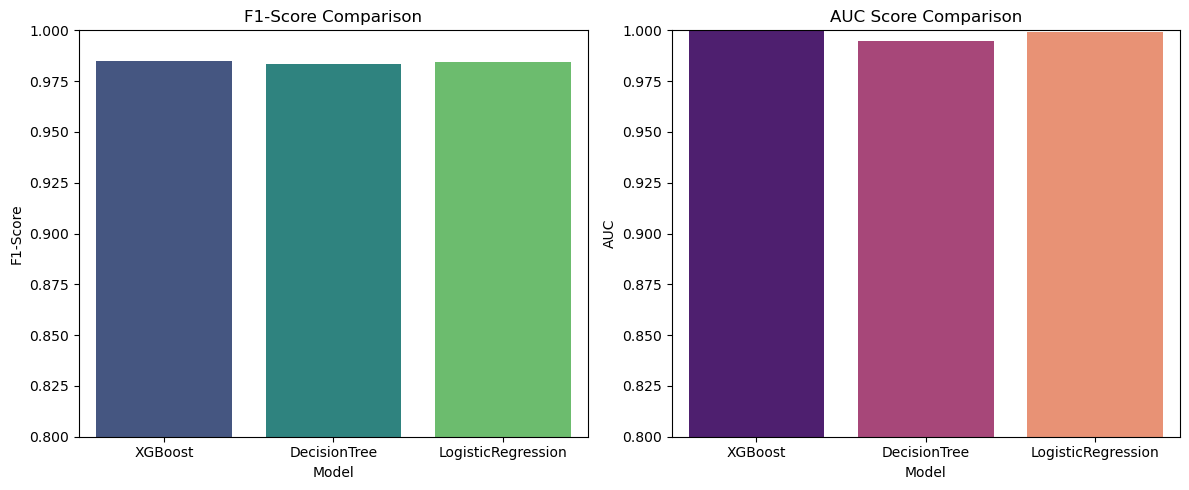

🏆 WINNER: XGBoost


In [14]:
results_df = pd.DataFrame(all_results).set_index('Model')
print("📊 BẢNG XẾP HẠNG MODEL:")
display(results_df.sort_values('F1-Score', ascending=False))

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y=results_df['F1-Score'], palette='viridis')
plt.title('F1-Score Comparison')
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y=results_df['AUC'], palette='magma')
plt.title('AUC Score Comparison')
plt.ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

# Tự động chọn Best Model dựa trên F1-Score
best_model_name = results_df['F1-Score'].idxmax()
print(f"🏆 WINNER: {best_model_name}")

Vì mô hình logistic regression có performance tương đương và lại nhẹ hơn nhiều, nên ta sẽ dùng logistic regression.

In [15]:
best_model_name = 'LogisticRegression'
print(f"\n🚀 Đang huấn luyện lại {best_model_name} trên toàn bộ dữ liệu...")

final_model = models_config[best_model_name]
final_model.fit(X, y)

# Lưu Model và Feature List
joblib.dump(final_model, MODEL_OUTPUT_PATH)
joblib.dump(SELECTED_FEATURES, FEATURE_LIST_PATH)  # Lưu SELECTED_FEATURES

print(f"✅ Đã lưu {best_model_name} vào: {MODEL_OUTPUT_PATH}")
print(f"✅ Đã lưu Feature Names vào: {FEATURE_LIST_PATH}")


🚀 Đang huấn luyện lại LogisticRegression trên toàn bộ dữ liệu...
✅ Đã lưu LogisticRegression vào: ../../dataset_final/models\best_matcher.pkl
✅ Đã lưu Feature Names vào: ../../dataset_final/models\feature_names.pkl


## 6. Feature Importance (Của Best Model)
Xem feature nào quan trọng nhất với model được chọn:
- **XGBoost/DecisionTree:** Hiển thị Feature Importance
- **Logistic Regression:** Hiển thị Coefficients

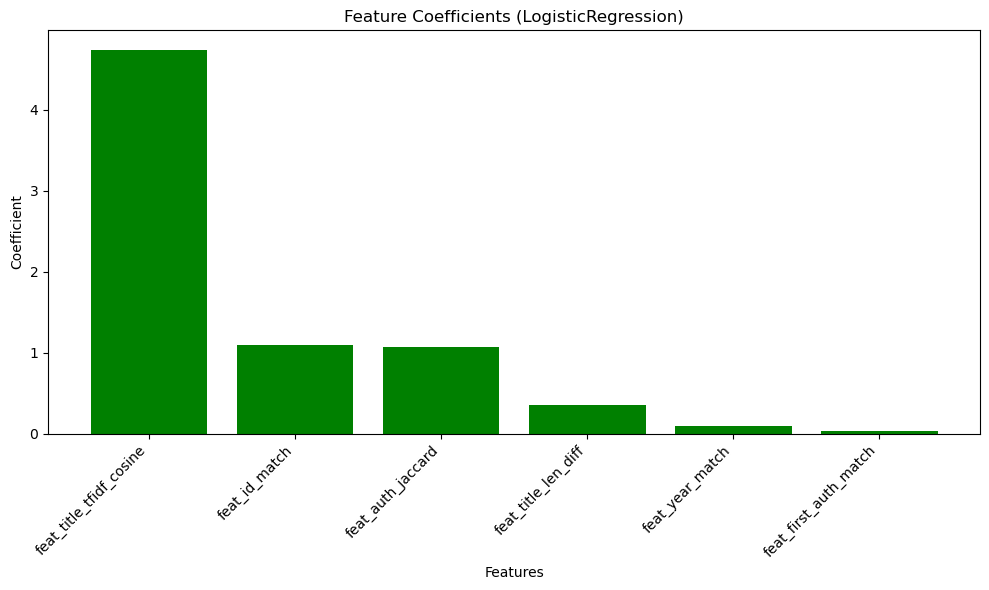


📊 Feature Importance Summary:
  1. feat_title_tfidf_cosine: +4.7460
  2. feat_id_match: +1.0988
  3. feat_auth_jaccard: +1.0695
  4. feat_title_len_diff: +0.3493
  5. feat_year_match: +0.0956
  6. feat_first_auth_match: +0.0308


In [16]:
plt.figure(figsize=(10, 6))

if best_model_name in ['XGBoost', 'DecisionTree']:
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [SELECTED_FEATURES[i] for i in indices]
    
    plt.title(f"Feature Importance ({best_model_name})")
    plt.bar(range(len(SELECTED_FEATURES)), importances[indices], color='steelblue')
    plt.xticks(range(len(SELECTED_FEATURES)), names, rotation=45, ha='right')
    plt.ylabel('Importance')

elif best_model_name == 'LogisticRegression':
    # Với Pipeline, truy cập step 'logisticregression'
    coefs = final_model.named_steps['logisticregression'].coef_[0]
    indices = np.argsort(abs(coefs))[::-1]
    names = [SELECTED_FEATURES[i] for i in indices]
    
    plt.title(f"Feature Coefficients ({best_model_name})")
    colors = ['green' if c > 0 else 'red' for c in coefs[indices]]
    plt.bar(range(len(SELECTED_FEATURES)), coefs[indices], color=colors)
    plt.xticks(range(len(SELECTED_FEATURES)), names, rotation=45, ha='right')
    plt.ylabel('Coefficient')

plt.xlabel('Features')
plt.tight_layout()
plt.show()

print(f"\n📊 Feature Importance Summary:")
for i, idx in enumerate(indices):
    if best_model_name in ['XGBoost', 'DecisionTree']:
        print(f"  {i+1}. {SELECTED_FEATURES[idx]}: {importances[idx]:.4f}")
    else:
        print(f"  {i+1}. {SELECTED_FEATURES[idx]}: {coefs[idx]:+.4f}")